In [1]:
%matplotlib inline

from __future__ import print_function, division

import os, sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, interactive, interact_manual
from IPython.html.widgets import FloatSlider, IntSlider, Dropdown
from IPython.html.widgets import Checkbox, RadioButtons, fixed 
from IPython.html import widgets
from IPython.display import display, clear_output


from astropy.convolution import convolve, Gaussian1DKernel

import seaborn as sns
sns.set(context="poster", font_scale=1.5)

# from bokeh import mpl
# from bokeh.plotting import show, output_notebook
# output_notebook()


## import from local files

## Boilerplate path hack to give access to full SNe package
import sys
if __package__ is None:
    if os.pardir not in sys.path[0]:
        file_dir = os.getcwd()
        sys.path.insert(0, os.path.join(file_dir, 
                                        os.pardir, 
                                        os.pardir))

from SNe.analysis.constants import m_proton, pc, yr, M_solar, \
                                   gamma, E_0, metallicity_solar
    
from SNe.analysis.sedov.dimensionalize_sedov import dimensionalized_sedov
from SNe.analysis.sedov.closed_form_sedov import SedovSolution
from SNe.analysis.parameter_study_file_structure import make_dirname_from_properties
from SNe.analysis.parse import RunSummary, parse_run, cols


general_exponential_format = "%.2e" # for formatting strings


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
class InnerWidget(object):
    """ 
        Allows a pointer to the single_run interact widget to be stored as a static variable
            - at some point I should find a better way to do this
    """
    def __init__(self):
        super(InnerWidget, self).__init__()
    w = None

    
#### These are needed for both the plotting and parsing routines    

cols_plot = cols[0:7] + cols[8:] 
cols_plot_linear = [cols[i] for i in [6, 10]]

label_dict = {"Radius"      :"$R$ [pc]", 
              "Velocity"    : r"$U$ [cm s$^{-1}$]",
              "Density"     : r"$\rho$  [g cm$^{-3}$]",
              "Temperature" : r"$T$ [K]",
              "Mass"        : r"$M$ [$M_\odot$]",
              "M_int"       : r"$M_\mathrm{int}$ [$M_\odot$]",
              "C_ad"        : r"$C_{ad}$ [cm s$^{-1}$]",
              "Energy"      : r"$E_{int}$ [erg g$^{-1}$]",
              "Pressure"    : r"$P$ [dyne cm$^{-2}$]",
              "Entropy"     : r"$S$ [$k_B$ / particle]",
              "M_int"       : r"$M_{int}$ [$M_\odot$]",
              "dR"          : r"$\Delta R$ [cm]",
              "dV"          : r"$\Delta V$ [cm$^3$]",
              "X"           : r"$X$ (passive scalar)",
              "Alpha"       : r"$\alpha$ (turbulence strength)", 
              "zones"       : r"zones"
             }

    
def plotter(last_run,
            checkpoint_filenames, 
            metallicity, background_density, background_temperature,
            sedov_solution,
            x_axis_variable  = "Radius",
            y_axis_variable  = "Density",
            with_Sedov       = True,
            outer_limit_log  = 0, 
            checkpoint_index = 0):
    
    df_tmp = last_run.df.loc[checkpoint_index]

    checkpoint_filename = checkpoint_filenames[checkpoint_index]
    time = last_run.times[checkpoint_index]
    
    E_kin = sedov_solution.E_kin
    E_int = sedov_solution.E_int
    print("E_kin: ", general_exponential_format % E_kin)
    print("E_int: ", general_exponential_format % E_int)
    momentum = sedov_solution.get_momentum(time=time - last_run.times[0])

    print("checkpoint: ",
          checkpoint_filename)
    print("time:                      ",
          general_exponential_format % (time / yr), "[yr]")
    print("zones:                     ",
          df_tmp.shape[0])
    print("energy conserved to:       ", 
          general_exponential_format % ((last_run.E_tot[checkpoint_index] - last_run.E_tot[0]) / last_run.E_tot[0]))
    print("E_kin    accurate to:      ", 
          general_exponential_format % ((last_run.E_kin[checkpoint_index] - E_kin) / E_kin))
    print("momentum accurate to:      ", 
          general_exponential_format % ((last_run.momentum[checkpoint_index] - momentum) / momentum))
    # # DON'T USE E_INT AS A METRIC, since you accrete in thermal energy
#     print("E_int accurate to:         ", 
#           (last_run.E_int[checkpoint_index] - E_int) / E_int)
    print("Peak luminosity at checkpoint", np.argmax(last_run.times == last_run.t_0) )
    print("Peak luminosity at t_0 =   ",
          general_exponential_format % (last_run.t_0 / yr), "[yr]")
    print("t_f = 13 * t_0 =           ",
          general_exponential_format % (last_run.t_f / yr), "[yr]")
    print("R_shock =                  ",
          "%3.2f" % (last_run.R_shock[checkpoint_index] / pc), "[pc]")
    print("E_R_tot =                  ",
          general_exponential_format % last_run.E_R_tot[checkpoint_index], "[ergs]")
    print("background_density:        ", 
          "%3.2f" % background_density)
    print("Number of SNe:             ", last_run.SNe_times.size)
    
    if x_axis_variable is "Radius":
        plt.xlim((0,10**outer_limit_log))

    marker = "."
    plt.plot(df_tmp[x_axis_variable], df_tmp[y_axis_variable], 
             marker=marker,
             label="numeric",
             drawstyle="steps")  

    if y_axis_variable in cols_plot_linear:
        plt.yscale("linear")
    else:
        plt.yscale("log")
    # Set and fix limits
    y_min, y_max = plt.ylim()
    plt.ylim( (y_min / 5, y_max * 5) )
    if y_axis_variable is "Velocity":
        plt.ylim(ymin=1)
    
    
    if with_Sedov is True:
        sedov_x_axes = ["Radius", "M_int"]
        if x_axis_variable in sedov_x_axes:
            sedov_cols = ["Radius", "Velocity", "Density", "Temperature",
                          "C_ad", "Energy", "Pressure", "Entropy", "Mass"]
            sedov_cols_plot = sedov_cols[:-1]
            
            if y_axis_variable in sedov_cols_plot:
                sedov = dimensionalized_sedov(time - last_run.times[0],
                                              metallicity=metallicity, 
                                              background_density=background_density,
                                              background_temperature=background_temperature)
                sedov = np.array(sedov).transpose()
                df_sedov = pd.DataFrame.from_records(sedov, 
                                                     columns=sedov_cols)
                df_sedov.Radius  /= pc
                df_sedov.Mass    /= M_solar
                df_sedov["M_int"] = df_sedov.Mass.cumsum()

                plt.plot(df_sedov[x_axis_variable], df_sedov[y_axis_variable], 
                         label="analytic (no cooling)")  

    plt.xlabel(label_dict[x_axis_variable])
    plt.ylabel(label_dict[y_axis_variable])

    plt.legend(loc="best")
    

    
    
    
def single_run(data_dir="", id="", last_run=None):

    if type(last_run) is not RunSummary:
        last_run = RunSummary()
    
    parse_results = parse_run(data_dir=data_dir, id=id, last_run=last_run)
    sedov_solution = SedovSolution(E_0,
                                   parse_results.background_density, 
                                   parse_results.metallicity)
    
    #### PASS TO PLOTTER ####
    num_checkpoints = len(parse_results.checkpoint_filenames)
    
    log_R_max = round(np.log10(last_run.df["Radius"].max()), 2)
    log_R_min = max(log_R_max-4, 
                    round(np.log10(last_run.df["Radius"].min()), 2)+1)
                
    if type(InnerWidget.w) is widgets.widget_box.Box:
        InnerWidget.w.close()
        
    w = interactive(plotter,
            last_run               = fixed(last_run),
            checkpoint_filenames   = fixed(parse_results.checkpoint_filenames),
            metallicity            = fixed(parse_results.metallicity),
            background_density     = fixed(parse_results.background_density),
            background_temperature = fixed(parse_results.background_temperature),
            sedov_solution         = fixed(sedov_solution),
            outer_limit_log        = FloatSlider(min=log_R_min, max=log_R_max, step=0.1, value=log_R_max),
            checkpoint_index       = IntSlider(min=0, max=num_checkpoints-1, step=0, value=num_checkpoints-1),
            y_axis_variable        = Dropdown(options=cols_plot, value="Density"),
            x_axis_variable        = RadioButtons(options=["Radius", "M_int", "zones"]))


    InnerWidget.w = w
    display(w)
    

E_kin:  2.85e+50
E_int:  7.15e+50
checkpoint:  ../src/8A6F7D5A-E24D-4FB9-B8D3-282BCE0E6EB3_checkpoint_0008.dat
time:                       8.02e+06 [yr]
zones:                      906
energy conserved to:        -8.00e-01
E_kin    accurate to:       -4.77e-01
momentum accurate to:       -4.42e-01
Peak luminosity at checkpoint 3
Peak luminosity at t_0 =    7.92e+06 [yr]
t_f = 13 * t_0 =            1.03e+08 [yr]
R_shock =                   32.65 [pc]
E_R_tot =                   2.17e+50 [ergs]
background_density:         0.00
Number of SNe:              2


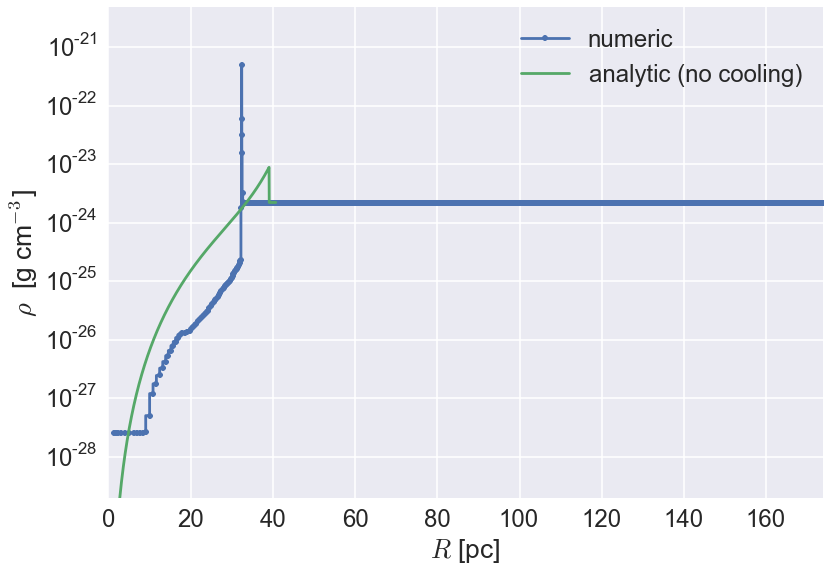

In [8]:
last_run = RunSummary()

data_dir = "../src"

id = "" # you don't need the full uuid, just enough to distinguish it

single_run(data_dir=data_dir, id=id, last_run=last_run)

In [22]:
last_run = RunSummary()

def parameter_study_wrapper(log_n, log_Z, T=1e4, 
                            with_cooling=True, 
                            last_run=last_run):
    z_solar = metallicity_solar
    
    background_density     = 1.33 * m_proton * 10**log_n
    metallicity            = z_solar * 10**log_Z
    background_temperature = T
    
    data_dir = make_dirname_from_properties( background_density, 
                                             metallicity, 
                                             background_temperature,
                                             with_cooling)
    
    if os.path.isdir(data_dir):
        tmp = glob.glob(data_dir + "*checkpoint*.dat")        
        
        if len(tmp) is not 0:
            basename = os.path.basename(tmp[0])
            id = basename.split("checkpoint")[0]
            single_run(data_dir=data_dir, id=id, last_run=last_run)
            
        else:
            print("No data was found")
    else:
        print("No directory was found")
        
v = interact_manual(parameter_study_wrapper,
        log_Z = FloatSlider(min=-3.0, max=+0.5, step=0.5, value=0),
        log_n = FloatSlider(min=-3.0, max=+3.0, step=1.0, value=-1),
        T     = fixed(1e4),
        with_cooling = True, 
        last_run=fixed(last_run))

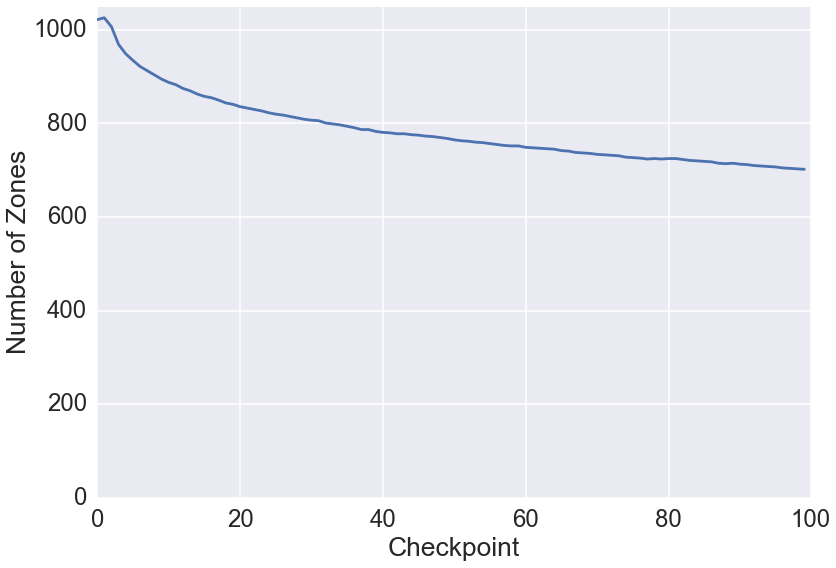

In [4]:
def plot_zones(last_run):
    if type(last_run) is RunSummary:
        if last_run.zones is not None:
            plt.figure()
            plt.plot(last_run.zones)
            plt.ylim(ymin=0)
            plt.ylabel("Number of Zones")
            plt.xlabel("Checkpoint")

plot_zones(last_run)

In [5]:
def SNe_rugplot(last_run):
    SNe_times = last_run.SNe_times / yr
    if SNe_times.size == 1:
        SNe_times = np.tile(SNe_times, 2) #seaborn can't do a rug plot of 1 point
    sns.rugplot(SNe_times)

<function __main__.plot_energy>

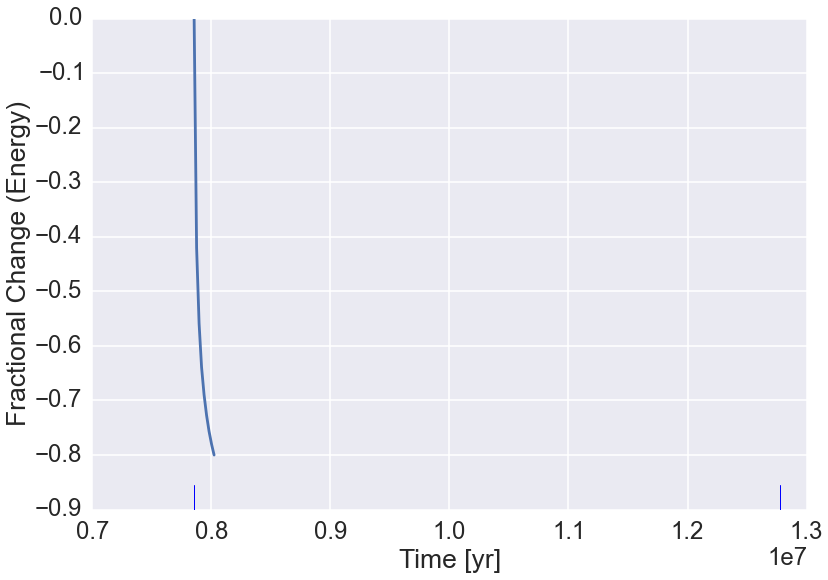

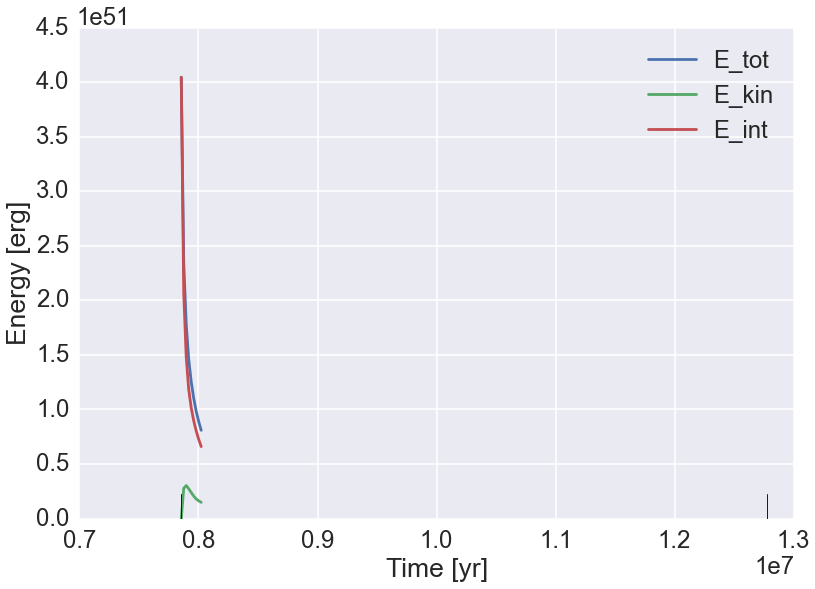

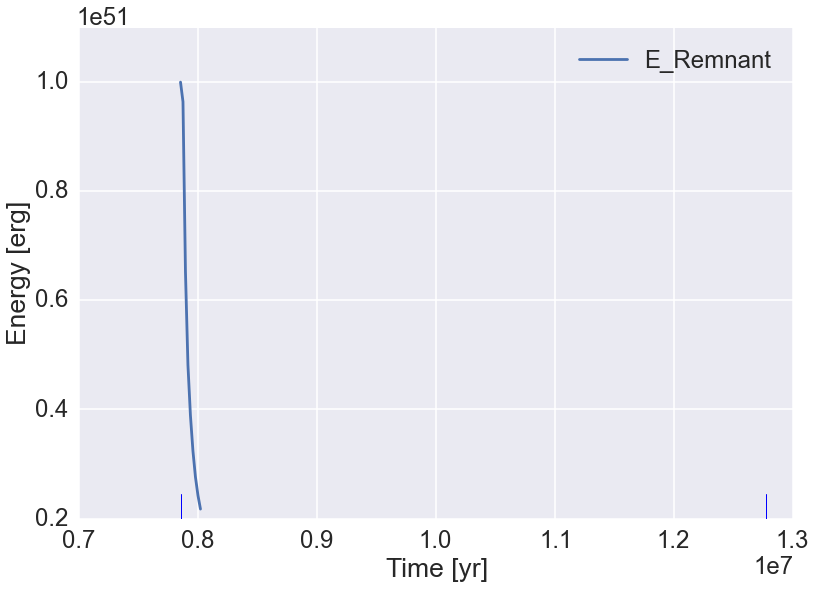

In [11]:
def plot_energy(last_run, x_axis):
    if type(last_run) is RunSummary:
        if ( (last_run.E_tot is not None) and
             (last_run.E_int is not None) and
             (last_run.E_kin is not None) ):
            
            plt.figure()
            
            if x_axis is "time":
                x_variable = last_run.times / yr
                xlabel = "Time [yr]"
                xscale = "linear"
                plt.xscale(xscale)
                xfmt = plt.gca().get_xaxis().get_major_formatter() # needs to be set AFTER plt.xscale()
                if xscale is "log":
                    mask = x_variable > 1
                elif xscale is "linear":
                    mask = np.full_like(x_variable, True, dtype=bool) 
                    xfmt.set_powerlimits((-2, 2)) # force scientific notation outside this range

            else:
                x_variable = np.arange(len(last_run.times))
                xlabel = "Checkpoint"
                xscale = "linear"
                mask = np.full_like(x_variable, True, dtype=bool) 

                plt.xscale(xscale)
                xfmt = plt.gca().get_xaxis().get_major_formatter() # needs to be set AFTER plt.xscale()

                
            
            E_err = (last_run.E_tot - last_run.E_tot[0]) / last_run.E_tot[0]
            plt.plot(x_variable[mask], E_err[mask])
            plt.xscale(xscale)
            plt.xlabel(xlabel)   
            plt.gca().xaxis.set_major_formatter(xfmt)
            plt.ylabel("Fractional Change (Energy)")
            if x_axis is "time":
                SNe_rugplot(last_run)
        
            plt.figure()
            plt.plot(x_variable[mask], last_run.E_tot[mask], label="E_tot" )
            plt.plot(x_variable[mask], last_run.E_kin[mask], label="E_kin" )
            plt.plot(x_variable[mask], last_run.E_int[mask], label="E_int" )
            plt.legend(loc="best")
            plt.xscale(xscale)
            plt.xlabel(xlabel) 
            plt.gca().xaxis.set_major_formatter(xfmt)
            plt.ylabel("Energy [erg]")
            if x_axis is "time":
                SNe_rugplot(last_run)
            
            plt.figure()
            plt.plot(x_variable[mask], last_run.E_R_tot[mask], label="E_Remnant" )
            plt.legend(loc="best")
            plt.xscale(xscale)
            plt.xlabel(xlabel)  
            plt.gca().xaxis.set_major_formatter(xfmt)
            plt.ylabel("Energy [erg]")
            if x_axis is "time":
                SNe_rugplot(last_run)
            

            
interact(plot_energy,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]))

<function __main__.plot_momentum>

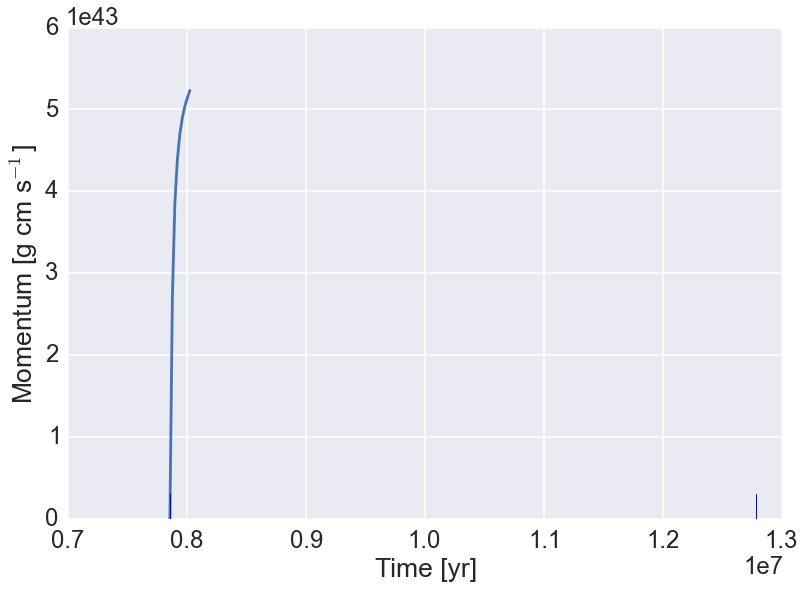

In [10]:
def plot_momentum(last_run, x_axis):
    if type(last_run) is RunSummary:

        plt.figure()

        if x_axis is "time":
            x_variable = last_run.times / yr
            xlabel = "Time [yr]"
            xscale = "linear"
            plt.xscale(xscale)
            xfmt = plt.gca().get_xaxis().get_major_formatter() # needs to be set AFTER plt.xscale()
            if xscale is "log":
                mask = x_variable > 1
            elif xscale is "linear":
                mask = np.full_like(x_variable, True, dtype=bool) 
                xfmt.set_powerlimits((-2, 2)) # force scientific notation outside this range

        else:
            x_variable = np.arange(len(last_run.times))
            xlabel = "Checkpoint"
            xscale = "linear"
            mask = np.full_like(x_variable, True, dtype=bool) 

            plt.xscale(xscale)
            xfmt = plt.gca().get_xaxis().get_major_formatter() # needs to be set AFTER plt.xscale()

        plt.plot(x_variable[mask], last_run.momentum[mask])
        plt.xscale(xscale)
        plt.xlabel(xlabel)   
        plt.gca().xaxis.set_major_formatter(xfmt)
        plt.ylabel(r"Momentum [g cm s$^{-1}$]")
        
        if x_axis is "time":
            SNe_rugplot(last_run)
            

            
interact(plot_momentum,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]))

Luminosity max at checkpoint:  3


<function __main__.plot_luminosity>

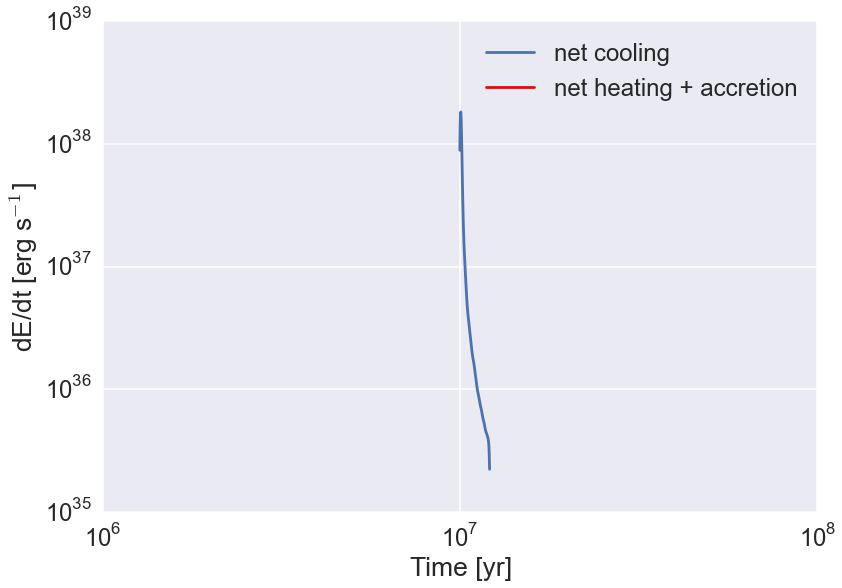

In [42]:
def plot_luminosity(last_run, x_axis):
    if type(last_run) is RunSummary:
        plt.figure()
        if x_axis is "time":
            x_variable = last_run.times / yr
            xlabel = "Time [yr]"
            xscale = "log"
            if xscale is "log":
                mask = x_variable > 1
            else:
                mask = np.full_like(x_variable, True, dtype=bool)
                xfmt.set_powerlimits((-2, 2)) # force scientific notation outside this range

        else:
            x_variable = np.arange(len(last_run.times))
            xlabel = "Checkpoint"
            xscale = "linear"
            mask = np.full_like(x_variable, True, dtype=bool)
        
        y_data = last_run.Luminosity[mask]
        gauss_kernel = Gaussian1DKernel(2)
        y_data = convolve(y_data, gauss_kernel)
        
        plt.plot(x_variable[mask],  y_data, label="net cooling")
        plt.plot(x_variable[mask], -y_data, label="net heating + accretion", color="r")
        plt.xlabel(xlabel)
        plt.xscale(xscale)
        plt.ylabel(r"dE/dt [erg s$^{-1}$]")
        plt.yscale("log")
        plt.legend()
        
        xfmt = plt.gca().get_xaxis().get_major_formatter()

        plt.gca().xaxis.set_major_formatter(xfmt)
        print("Luminosity max at checkpoint: ", np.argmax(last_run.t_0 == last_run.times))


interact(plot_luminosity,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]))


In [56]:
high_res = RunSummary()
data_dir = ".."
id = "8c8" # you don't need the full uuid, just enough to distinguish it
single_run(data_dir=data_dir, id=id, last_run=high_res)

low_res = RunSummary()
data_dir = ".."
id = "3eac" # you don't need the full uuid, just enough to distinguish it
single_run(data_dir=data_dir, id=id, last_run=low_res)



plt.plot(1- (high_res.E_tot / low_res.E_tot), label="E_tot")
plt.plot(1- (high_res.E_kin / low_res.E_kin), label="E_kin")
plt.plot(1- (high_res.E_int / low_res.E_int), label="E_int")
plt.legend(loc="best")

IndexError: list index out of range